In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
# import matplotlib.

%matplotlib inline

In [2]:
points = np.mgrid[-0.5:1:0.5, -0.5:1:0.5, -0.5:1:0.5].reshape(3, -1).T
colors = plt.cm.viridis(np.arange(len(points))/len(points))

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


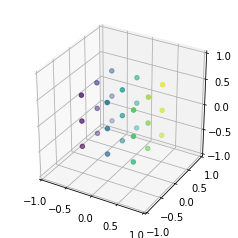

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
ax.scatter(*points.T, c=colors)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1);
fig.show()

In [9]:
cam1 = {
    'position': np.array([3, -3, 2]),
    'target': np.array([0, 0, 0]),
    'up': np.array([0, 0, 1]),
    'focal_length': 0.0600,
    'film_width': 0.0350,
    'film_height': 0.0350,
    'width': 256,
    'height': 256,
}

cam2 = {
    'position': np.array([2, 3, 3]),
    'target': np.array([0, 0, 0]),
    'up': np.array([0, 0, 1]),
    'focal_length': 0.0600,
    'film_width': 0.0350,
    'film_height': 0.0350,
    'width': 256,
    'height': 256,
}

In [10]:
def get_elev_azim(cam):
    pos = np.array(cam['position'])
    azim = np.arctan2(pos[1], pos[0]) * 180/np.pi
    r = np.sqrt(pos[0]**2 + pos[1]**2)
    elev = (np.arctan2(pos[2], r)) * 180/np.pi
    return elev, azim
def camera_coordinate_system(cam):
    zcam = np.array(cam['target']) - np.array(cam['position']);
    xcam = np.cross(zcam, cam['up']);

    ycam = np.cross(zcam, xcam);
    zcam = zcam / np.linalg.norm(zcam);
    xcam = xcam / np.linalg.norm(xcam);
    ycam = ycam / np.linalg.norm(ycam);
    origin = cam['position'];
    return [xcam, ycam, zcam, origin]
def get_verts(cam):
    xcam, ycam, zcam, origin = camera_coordinate_system(cam);

    d = np.linalg.norm(cam['target']-cam['position']);
    x = 0.5 * cam['film_width'] * d / cam['focal_length'];
    y = 0.5 * cam['film_height'] * d / cam['focal_length'];

    P1 = origin + x * xcam + y * ycam + d * zcam;
    P2 = origin + x * xcam - y * ycam + d * zcam;
    P3 = origin - x * xcam - y * ycam + d * zcam;
    P4 = origin - x * xcam + y * ycam + d * zcam;
    return np.array([P1, P2, P3, P4])

Text(0.5,0.92,'Red is Camera 1, Blue is Camera 2')

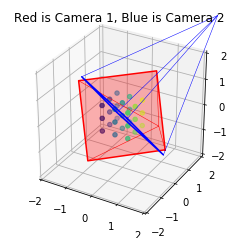

In [11]:
cam = cam1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
ax.scatter(*points.T, c=colors)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2);

for cam in [cam1, cam2]:
    vs = get_verts(cam)
    pc = Poly3DCollection([vs])
    pc.set_alpha(0.3)   # Order reversed 
    if cam is cam1:
        c='r'
    else:
        c='b'
    pc.set_facecolor(c)

    for i in range(4):
        ax.plot(*zip(vs[i], cam['position']), color=c, lw=0.5)
    ax.plot([vs[i%4, 0] for i in range(5)], [vs[i%4, 1] for i in range(5)], [vs[i%4, 2] for i in range(5)], color=c)
    ax.add_collection3d(pc, zs='z')
ax.legend(loc='best')
ax.set_title('Red is Camera 1, Blue is Camera 2')
# ax.view_init(*get_elev_azim(cam))

In [12]:
def extrinsic_matrix(cam):
    xcam, ycam, zcam, origin = camera_coordinate_system(cam)
    R = np.vstack((xcam, ycam, zcam)).T
    M = np.vstack((R, -origin @ R))
    return M
def intrinsic_matrix(cam):
    cx = (cam['width']+1) * 0.5;
    cy = (cam['height']+1) * 0.5;

    fx = cam['focal_length'] * cam['width'] / cam['film_width'];
    fy = cam['focal_length'] * cam['height'] / cam['film_height'];
    K = np.array([[fx, 0, 0], [0, fy, 0], [cx, cy, 1]])
    return K
def camera_matrix(cam):
    return extrinsic_matrix(cam) @ intrinsic_matrix(cam)
def world_to_xy(cam, points):
    P = camera_matrix(cam)
    points = np.hstack((points, np.ones((len(points), 1)))) @ P
    x = points[:, 0] / points[:, 2]
    y = points[:, 1] / points[:, 2]
    return np.vstack((x,y)).T
def draw_image(centers, colors, R, imshape=(256, 256)):
    im = np.zeros((*imshape, 4))
    for ix, (color, center) in enumerate(zip(colors, centers)):
        for x in range(-R, R+1):
            for y in range(-R, R+1):
                if (x**2+y**2) <= R**2:
                    im[int(center[0] + x), int(center[1] + y)] = color
    return im

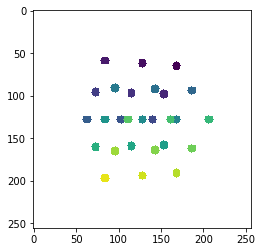

In [13]:
plt.imshow(draw_image(world_to_xy(cam1, points), colors, 5))